# Тема: Feature Engineering, Feature Selection, part II

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

import shap
shap.initjs()

from xgboost import XGBClassifier

import warnings
warnings.simplefilter("ignore")

pd.options.display.max_columns = 500

Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

In [2]:
data = pd.read_csv('data/assignment2_data/train_trans.csv')
lb = pd.read_csv('data/assignment2_data/test_trans.csv')

X_data = data.drop('isFraud', axis=1)
y_data = data['isFraud']

X_lb = lb.drop('isFraud', axis=1)
y_lb = lb['isFraud']

### Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

In [3]:
class EvaluationModel():
    
    def __init__(self, X: pd.DataFrame, 
                       y: pd.Series = None, 
                       stata_model: pd.DataFrame = None, 
                       operation: str = None):
        
        self.X = X.copy()
        self.y = y
        self.stata_model = stata_model
        self.operation = operation
        self.cat_features = X.select_dtypes(include=np.object).columns.to_list()
        
    def label_encoder(self):

        le = LabelEncoder()
        for feature in self.cat_features:
            cat_value = list(self.X[feature].values.astype('str'))
            le.fit(cat_value)
            self.X[feature] = le.transform(cat_value)

        return self.X
    
    def cross_validation(self, model):
    
        fold_train_scores, fold_valid_scores = [], []
        cv_strategy = KFold(n_splits=5, random_state=1, shuffle=True)

        for train_idx, valid_idx in cv_strategy.split(self.X, self.y):
            X_train_cv, X_valid_cv = self.X.loc[train_idx], self.X.loc[valid_idx]
            y_train_cv, y_valid_cv = self.y.loc[train_idx], self.y.loc[valid_idx]

            model.fit(X_train_cv, y_train_cv)
            y_train_cv_pred = model.predict_proba(X_train_cv)[:, 1]
            y_valid_cv_pred = model.predict_proba(X_valid_cv)[:, 1]
            fold_train_scores.append(roc_auc_score(y_train_cv, y_train_cv_pred))
            fold_valid_scores.append(roc_auc_score(y_valid_cv, y_valid_cv_pred))

        train_scores = round(np.mean(fold_train_scores), 4)
        valid_scores = round(np.mean(fold_valid_scores), 4)

        conf_interval = 0.95 

        left_bound = np.percentile(fold_valid_scores, ((1 - conf_interval) / 2) * 100)
        right_bound = np.percentile(fold_valid_scores, (conf_interval + ((1 - conf_interval) / 2)) * 100)
        interval = f'{round(left_bound, 3)}/{round(right_bound, 3)}'

        return train_scores, valid_scores, interval
    
    def collection_statistic(self, model, X_train, y_train, X_valid, y_valid):
        
        train_scores, valid_scores, interval = self.cross_validation(model)
        
        self.stata_model.loc[f'{self.operation}', 'train_Hold_Out'] = \
                round(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]), 4)
        self.stata_model.loc[f'{self.operation}', 'valid_Hold_Out'] = \
                round(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]), 4)
        
        self.stata_model.loc[f'{self.operation}', 'train_KFold'] = train_scores
        self.stata_model.loc[f'{self.operation}', 'valid_KFold'] = valid_scores
        self.stata_model.loc[f'{self.operation}', 'valid_interval'] = interval
        
        return self.stata_model
    
    def xgb_classifier(self):
        
        self.X = self.label_encoder()
        
        X_train, X_valid = train_test_split(self.X, train_size=0.7, shuffle=True, random_state=5)
        y_train, y_valid = train_test_split(self.y, train_size=0.7, shuffle=True, random_state=5)
        
        params_xgb = {"n_estimators": 100,
                      "objective": "binary:logistic",
                      "eval_metric": "auc",
                      "random_state": 42}

        model_xgb = XGBClassifier(**params_xgb)
        model_xgb.fit(X=X_train, y=y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
                    early_stopping_rounds=25,
                    verbose=20)
        
        self.stata_model = self.collection_statistic(model_xgb, X_train, y_train, X_valid, y_valid)
        
        return model_xgb, self.stata_model

In [8]:
stata_model = pd.DataFrame(columns=['train_Hold_Out', 'valid_Hold_Out', 
                                    'train_KFold', 'valid_KFold', 'valid_interval'])

X_data_base = X_data.copy()
X_data_base.shape

(180000, 456)

In [4]:
model, stata_model = EvaluationModel(X_data_base, y_data, stata_model, operation='baseline').xgb_classifier()
stata_model

[0]	validation_0-auc:0.76400	validation_1-auc:0.75372
[20]	validation_0-auc:0.94588	validation_1-auc:0.91743
[40]	validation_0-auc:0.96856	validation_1-auc:0.92882
[60]	validation_0-auc:0.98226	validation_1-auc:0.93520
[80]	validation_0-auc:0.98781	validation_1-auc:0.93914
[99]	validation_0-auc:0.99224	validation_1-auc:0.94154
CPU times: user 29min 13s, sys: 3.76 s, total: 29min 17s
Wall time: 1min 22s


,train_Hold_Out,valid_Hold_Out,train_KFold,valid_KFold,valid_interval
baseline,0.9803,0.9794,0.9895,0.944,0.94/0.951


### Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

Text(0.5, 1.0, 'What are the top important features to start with?')

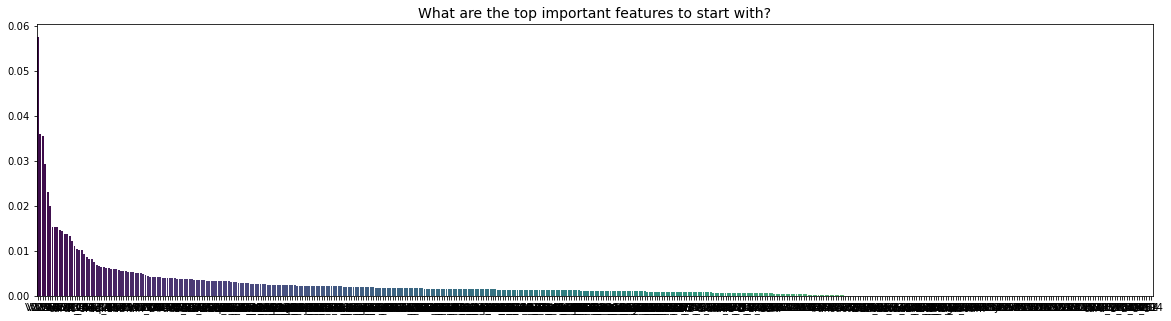

In [5]:
importances = model.feature_importances_
idx = np.argsort(importances)[::-1]
feature_names = X_data_base.columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

### Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [9]:
X_data_base_import_own = X_data_base.copy()

for i in idx:
    if importances[i]<=0:
        X_data_base_import_own.drop(feature_names[i], axis=1, inplace=True)
        
X_data_base_import_own.shape

(180000, 331)

In [7]:
model_own, stata_model = EvaluationModel(X_data_base_import_own, y_data, stata_model, 
                                        operation='importances_own').xgb_classifier()
stata_model

[0]	validation_0-auc:0.76400	validation_1-auc:0.75372
[20]	validation_0-auc:0.94514	validation_1-auc:0.91885
[40]	validation_0-auc:0.96597	validation_1-auc:0.93127
[60]	validation_0-auc:0.98018	validation_1-auc:0.93915
[80]	validation_0-auc:0.98753	validation_1-auc:0.94313
[99]	validation_0-auc:0.99085	validation_1-auc:0.94392


,train_Hold_Out,valid_Hold_Out,train_KFold,valid_KFold,valid_interval
baseline,0.9803,0.9794,0.9895,0.944,0.94/0.951
importances_own,0.979,0.9784,0.9881,0.9445,0.941/0.95


**Вывод**
- небольшое улучшение результата

### Задание 3: использовать permutation importance, выполнить задание 1 и 2.

In [10]:
X_data_base_import_perm = X_data_base.copy()

X_data_base_import_perm = EvaluationModel(X_data_base_import_perm).label_encoder()

X_train, X_valid = train_test_split(X_data_base_import_perm, train_size=0.7, shuffle=True, random_state=5)
y_train, y_valid = train_test_split(y_data, train_size=0.7, shuffle=True, random_state=5)

In [11]:
importance = permutation_importance(
    model, X_valid, y_valid, scoring="roc_auc", n_jobs=6, random_state=27
)

In [12]:
importance_scores = pd.DataFrame({
    "features": X_valid.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)

In [13]:
X_data_base_import_perm.drop(decrease_scores['features'], axis=1, inplace=True)
X_data_base_import_perm.shape

(180000, 268)

In [14]:
model_per, stata_model = EvaluationModel(X_data_base_import_perm, y_data, stata_model, 
                                        operation='importances_permutation').xgb_classifier()
stata_model

[0]	validation_0-auc:0.77297	validation_1-auc:0.77024
[20]	validation_0-auc:0.94277	validation_1-auc:0.91907
[40]	validation_0-auc:0.96719	validation_1-auc:0.92917
[60]	validation_0-auc:0.97727	validation_1-auc:0.93504
[80]	validation_0-auc:0.98639	validation_1-auc:0.93893
[99]	validation_0-auc:0.99055	validation_1-auc:0.94145


,train_Hold_Out,valid_Hold_Out,train_KFold,valid_KFold,valid_interval
baseline,0.9803,0.9794,0.9895,0.944,0.94/0.951
importances_own,0.979,0.9784,0.9881,0.9445,0.941/0.95
importances_permutation,0.981,0.9782,0.9898,0.9442,0.94/0.949


**Вывод**
- на валидационных данных результат немного уменьшился.

### Задание 4: использовать shap, выполнить задание 1 и 2.

In [15]:
X_data_base_import_shap = X_data_base.copy()

X_data_base_import_shap = EvaluationModel(X_data_base_import_shap).label_encoder()

X_train, X_valid = train_test_split(X_data_base_import_shap, train_size=0.7, shuffle=True, random_state=5)
y_train, y_valid = train_test_split(y_data, train_size=0.7, shuffle=True, random_state=5)

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

In [17]:
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)

features = rf_resultX.mean()[rf_resultX.mean()>0].index.to_list()

X_data_base_import_shap.drop(features, axis=1, inplace=True)
X_data_base_import_shap.shape

(180000, 347)

In [18]:
model_shap, stata_model = EvaluationModel(X_data_base_import_shap, y_data, stata_model, 
                                        operation='importances_shap').xgb_classifier()
stata_model

[0]	validation_0-auc:0.76477	validation_1-auc:0.75334
[20]	validation_0-auc:0.94535	validation_1-auc:0.92117
[40]	validation_0-auc:0.96588	validation_1-auc:0.92949
[60]	validation_0-auc:0.97964	validation_1-auc:0.93512
[80]	validation_0-auc:0.98674	validation_1-auc:0.94194
[99]	validation_0-auc:0.99107	validation_1-auc:0.94527


,train_Hold_Out,valid_Hold_Out,train_KFold,valid_KFold,valid_interval
baseline,0.9803,0.9794,0.9895,0.944,0.94/0.951
importances_own,0.979,0.9784,0.9881,0.9445,0.941/0.95
importances_permutation,0.981,0.9782,0.9898,0.9442,0.94/0.949
importances_shap,0.9812,0.9795,0.9898,0.9433,0.94/0.951


**Вывод**
- на валидационных данных результат уменьшился

### Задание 5: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

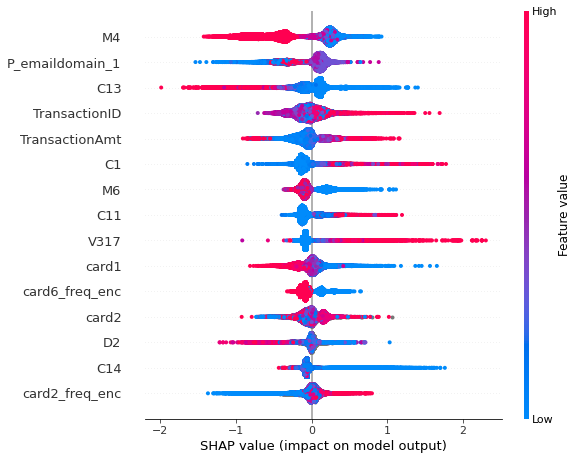

In [19]:
shap.summary_plot(shap_values, X_valid, max_display=15)

**Вывод**
- M4, card6_freg_enc - чем ниже значение признаков, тем большее влияние оказывают
- С1, C11, card2_freg_enc - чем выше значение признаков, тем большее влияние оказывают

In [21]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(40)
features = X_valid.iloc[select]
features_display = X_valid.loc[features.index]
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [-4.16006421]


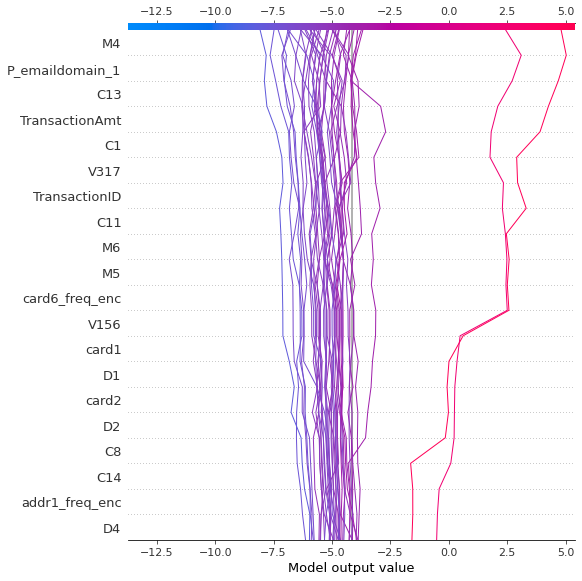

In [22]:
shap.decision_plot(expected_value, shap_values, features_display.iloc[:60])

**Вывод**
- С1, С11, С8 - больше, чем остальные оказывают влияние в положительную сторону
- D1, V317, С13 - больше, чем остальные оказывают влияние в отрицательную сторону
- два выбивающихся из общей картины признака справа скорее всего влияют на переобучение модели